<a href="https://colab.research.google.com/github/Bhumika20022/DSP-PROJECT/blob/main/dsp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

! mkdir ~/.kaggle

In [4]:

! cp kaggle.json ~/.kaggle/

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:

! chmod 600 ~/.kaggle/kaggle.json

In [7]:

! kaggle datasets download -d kenjee/z-by-hp-unlocked-challenge-3-signal-processing

100% 603M/604M [00:05<00:00, 128MB/s]
100% 604M/604M [00:05<00:00, 114MB/s]


In [23]:

!unzip z-by-hp-unlocked-challenge-3-signal-processing


Archive:  z-by-hp-unlocked-challenge-3-signal-processing.zip
  inflating: Forest Recordings/recording_00.mp3  
  inflating: Forest Recordings/recording_01.mp3  
  inflating: Forest Recordings/recording_02.mp3  
  inflating: Forest Recordings/recording_03.mp3  
  inflating: Forest Recordings/recording_04.mp3  
  inflating: Forest Recordings/recording_05.mp3  
  inflating: Forest Recordings/recording_06.mp3  
  inflating: Forest Recordings/recording_07.mp3  
  inflating: Forest Recordings/recording_08.mp3  
  inflating: Forest Recordings/recording_09.mp3  
  inflating: Forest Recordings/recording_10.mp3  
  inflating: Forest Recordings/recording_11.mp3  
  inflating: Forest Recordings/recording_12.mp3  
  inflating: Forest Recordings/recording_13.mp3  
  inflating: Forest Recordings/recording_14.mp3  
  inflating: Forest Recordings/recording_15.mp3  
  inflating: Forest Recordings/recording_16.mp3  
  inflating: Forest Recordings/recording_17.mp3  
  inflating: Forest Recordings/recordin

In [94]:
import tensorflow as tf
import tensorflow_io as tfio
from matplotlib import pyplot as plt
import os, csv
import IPython as IPD
from IPython.display import YouTubeVideo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from itertools import groupby

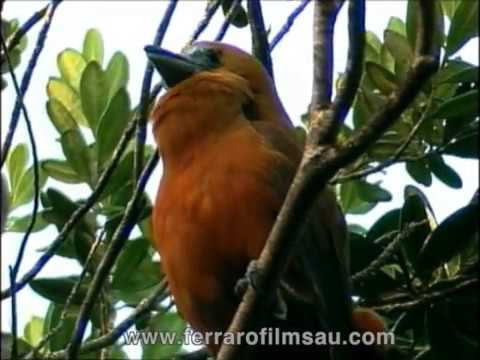

In [95]:
YouTubeVideo("cwHWpq79MCM")

In [96]:
ROOT = "/content/data"
capuchin_data = os.path.join(ROOT, "Parsed_Capuchinbird_Clips")
other_data = os.path.join(ROOT, "Parsed_Not_Capuchinbird_Clips")
forest_data = os.path.join(ROOT, "Forest_Recordings")

DOWNSAMPLE_RATE = 16000
EPOCHS = 10
EXAMPLE_FILE_CAPUCHIN = os.path.join(capuchin_data, "XC16803-1.wav")
EXAMPLE_FILE_NOT_CAPUCHIN = os.path.join(other_data, "afternoon-birds-song-in-forest-2.wav")

In [97]:
#Downsampling data from 44.1khz to xxx khz
def downsample_audio(filename, downsampling_rate, is_forest=False):
  file, to_tensor, sample_rate, wav = "","", "",""
  if is_forest:
    file = tfio.audio.AudioIOTensor(filename)
    to_tensor = file.to_tensor()
    to_tensor = tf.math.reduce_sum(to_tensor, axis=1) /2
    sample_rate = tf.cast(file.rate, dtype=tf.int64)
    wav = tfio.audio.resample(to_tensor, rate_in=sample_rate, rate_out=downsampling_rate)
  else:
    file = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=downsampling_rate)

  return wav

In [98]:
IPD.display.Audio(EXAMPLE_FILE_CAPUCHIN)

In [99]:
IPD.display.Audio(EXAMPLE_FILE_NOT_CAPUCHIN)

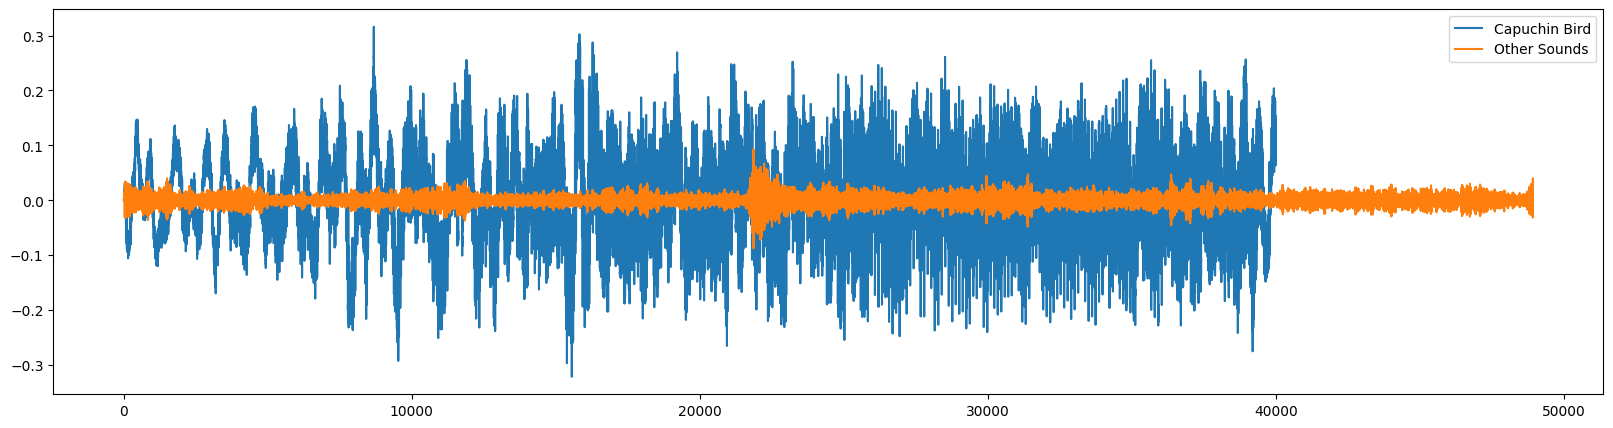

In [100]:
#Downsample and plot
plt.figure(figsize=(20,5))
plt.plot(downsample_audio(EXAMPLE_FILE_CAPUCHIN, DOWNSAMPLE_RATE))
plt.plot(downsample_audio(EXAMPLE_FILE_NOT_CAPUCHIN, DOWNSAMPLE_RATE))
plt.legend(['Capuchin Bird', 'Other Sounds'])
plt.show()

In [101]:
lengths = []

for file in os.listdir(capuchin_data):
  downsampled_audio = downsample_audio(os.path.join(capuchin_data, file), DOWNSAMPLE_RATE)
  lengths.append(len(downsampled_audio))

In [102]:
print(f"Longest call of the capuchin bird is {max(lengths)/DOWNSAMPLE_RATE} seconds")
print(f"Shortest call of the capuchin bird is {min(lengths)/DOWNSAMPLE_RATE} seconds")
print(f"Average call of the capuchin bird is {round(sum(lengths)/len(lengths))/DOWNSAMPLE_RATE} seconds")

Longest call of the capuchin bird is 5.0 seconds
Shortest call of the capuchin bird is 2.0 seconds
Average call of the capuchin bird is 3.3848125 seconds


In [103]:
selected_length = int(round(sum(lengths)/len(lengths),-3))
selected_length

54000

In [104]:
#Loading all data
pos = tf.data.Dataset.list_files(capuchin_data+'/*.wav')
neg = tf.data.Dataset.list_files(other_data+'/*.wav')

pos_dataset = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
neg_dataset = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
full_data = pos_dataset.concatenate(neg_dataset)

In [105]:
def preprocess_data(file_path, label):
  file_audio = downsample_audio(file_path, DOWNSAMPLE_RATE)
  file_audio = file_audio[:selected_length]
  zero_padding = tf.zeros([selected_length] - tf.shape(file_audio), dtype=tf.float32)
  file_audio = tf.concat([zero_padding, file_audio], 0)
  spectrogram = tf.abs(tf.signal.stft(file_audio, frame_length=320, frame_step=32))
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [106]:
def preprocess_data_full_audio(sample, label):
  file_audio = sample[0]
  zero_padding = tf.zeros([selected_length] - tf.shape(file_audio), dtype=tf.float32)
  file_audio = tf.concat([zero_padding, file_audio], 0)
  spectrogram = tf.abs(tf.signal.stft(file_audio, frame_length=320, frame_step=32))
  spectrogram = tf.expand_dims(spectrogram, axis=2)
  return spectrogram, label

In [107]:
import numpy as np
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

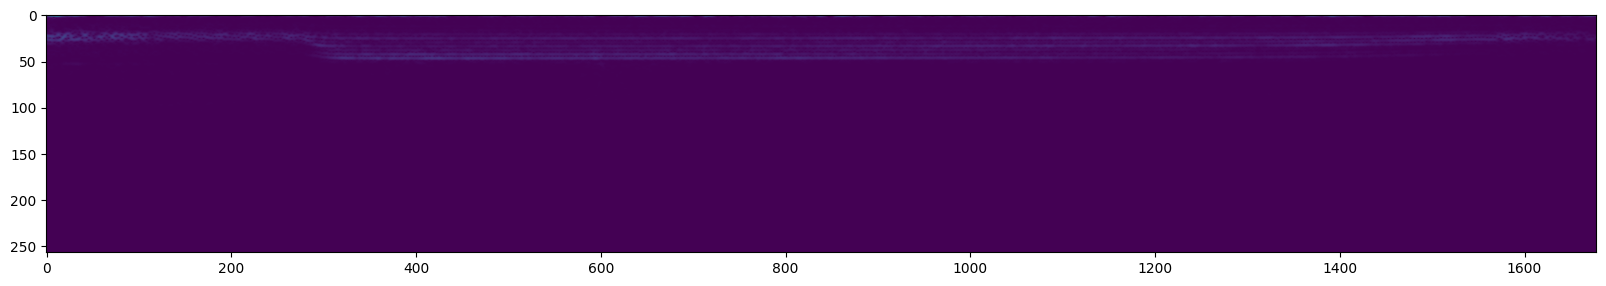

In [108]:
filepath, label = pos_dataset.shuffle(buffer_size=1000).as_numpy_iterator().next()
spectrogram , label = preprocess_data(filepath, label)
plt.figure(figsize=(20,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

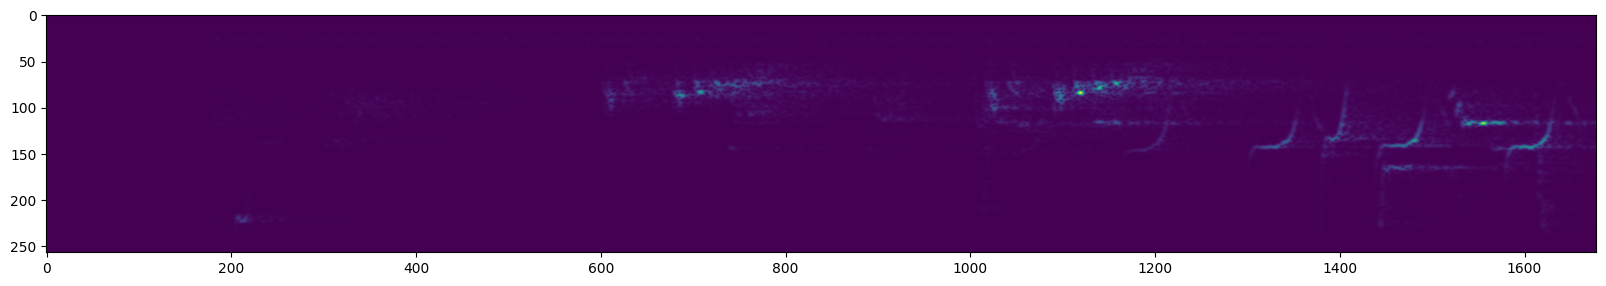

In [109]:
filepath, label = neg_dataset.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram , label = preprocess_data(filepath, label)
plt.figure(figsize=(20,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [110]:
#Data Pipeline
full_data_pipeline = full_data.map(preprocess_data).cache().shuffle(buffer_size=1000).batch(16).prefetch(8)

In [111]:
total = int(len(full_data_pipeline))
train_data = full_data_pipeline.take(int(total*0.7))
val_data = full_data_pipeline.skip(int(total*0.7)).take(int(total*0.1))
test_data = full_data_pipeline.skip(int(total*0.7)).skip(int(total*0.1)).take(int(total*0.2))

In [112]:
print('Training batch size', len(train_data))
print('Validation batch size', len(val_data))
print('Test batch size', len(test_data))

Training batch size 35
Validation batch size 5
Test batch size 10


In [113]:
samples, labels = train_data.as_numpy_iterator().next()
samples.shape

(16, 1678, 257, 1)

In [114]:
labels

array([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [116]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten

In [121]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1678, 257, 1)))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=3, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [122]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [123]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 1676, 255, 16)     160       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 838, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 836, 126, 16)      2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 418, 63, 16)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 421344)            0         
                                                                 
 dense_5 (Dense)             (None, 128)              

In [125]:
hist = model.fit(train_data, epochs=5, validation_data=test_data, callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,
                                               patience=5,
                                               restore_best_weights=True
                                              ),)

Epoch 1/5
35/35 [==============================] - 145s 4s/step - loss: 0.1173 - recall_3: 0.8759 - precision_3: 0.9549 - val_loss: 0.0268 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 2/5
35/35 [==============================] - 145s 4s/step - loss: 0.0235 - recall_3: 0.9931 - precision_3: 0.9863 - val_loss: 0.0061 - val_recall_3: 1.0000 - val_precision_3: 1.0000
Epoch 3/5
35/35 [==============================] - 144s 4s/step - loss: 0.0405 - recall_3: 0.9796 - precision_3: 0.9863 - val_loss: 0.0737 - val_recall_3: 0.9318 - val_precision_3: 1.0000
Epoch 4/5
35/35 [==============================] - 148s 4s/step - loss: 0.0769 - recall_3: 0.9799 - precision_3: 0.9733 - val_loss: 0.0294 - val_recall_3: 0.9535 - val_precision_3: 1.0000
Epoch 5/5
35/35 [==============================] - 153s 4s/step - loss: 0.0146 - recall_3: 1.0000 - precision_3: 0.9933 - val_loss: 9.4085e-04 - val_recall_3: 1.0000 - val_precision_3: 1.0000


In [132]:
test_audio = []
test_labels = []
cnt = 0

for X_test, y_test in test_data.as_numpy_iterator():

    y_hat = model.predict(X_test)
    y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]
    print(f'Predicted labels: {y_hat}')
    print(f'True labels: {y_test}')
    for idx, item in enumerate(y_hat):
        if item == y_test[idx]:
            cnt+=1
    print(f'Accuracy is {(cnt/16)*100} %')
    cnt = 0

1/1 [==============================] - 1s 1s/step
Predicted labels: [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
True labels: [0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
Accuracy is 100.0 %
1/1 [==============================] - 1s 896ms/step
Predicted labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
True labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 1s 1s/step
Predicted labels: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]
True labels: [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 2s 2s/step
Predicted labels: [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
True labels: [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Accuracy is 100.0 %
1/1 [==============================] - 2s 2s/step
Predicted labels: [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1]
True labels: [0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
Accuracy is 100.0